In [122]:
import numpy as np
from pandas import read_excel, DataFrame, get_dummies
from matplotlib import pyplot as plt
import seaborn as sb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [123]:
origin = read_excel("tdf.xlsx")
origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1009 entries, 0 to 1008
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   상권_코드        1009 non-null   int64  
 1   상권_코드_명      1009 non-null   object 
 2   점포수_x        1009 non-null   float64
 3   도심_x         1009 non-null   int64  
 4   총_직장_인구_수_x  1009 non-null   float64
 5   총_생활인구_수_x   1009 non-null   float64
 6   점포수_y        1009 non-null   float64
 7   총_직장_인구_수_y  1009 non-null   int64  
 8   총_생활인구_수_y   1009 non-null   float64
 9   매출증감         1009 non-null   int64  
dtypes: float64(5), int64(4), object(1)
memory usage: 79.0+ KB


### 03. 데이터 전처리
#### 결측치 확인

In [124]:
origin.isna().sum()


상권_코드          0
상권_코드_명        0
점포수_x          0
도심_x           0
총_직장_인구_수_x    0
총_생활인구_수_x     0
점포수_y          0
총_직장_인구_수_y    0
총_생활인구_수_y     0
매출증감           0
dtype: int64

### 05. 데이터셋 분할하기
#### 랜덤시드 고정

In [125]:
np.random.seed(666)

#### 훈련 데이터(독립변수)와 레이블(종속변수) 구분하기


In [126]:
x= origin.drop(['상권_코드', '상권_코드_명', '매출증감'], axis=1)
x.head()

,점포수_x,도심_x,총_직장_인구_수_x,총_생활인구_수_x,점포수_y,총_직장_인구_수_y,총_생활인구_수_y
0,6.825688,1,21133.770642,1.063927e+06,6.564356,13700,1.108208e+06
1,4.519231,1,10343.230769,3.304633e+06,4.493333,11773,3.704169e+06
2,7.094340,1,43510.654088,2.169122e+06,7.382550,39506,1.775981e+06
3,4.418182,1,8267.454545,2.516156e+06,4.390000,1696,3.109088e+06
4,3.263158,1,2711.131579,3.022949e+05,3.417910,4252,4.745286e+05


In [127]:
y = origin[['매출증감']]
y.head()

,매출증감
0,0
1,0
2,0
3,0
4,0


#### 데이터 표준화
명목형을 제거한 임시 데이터프레임을 생성

In [128]:
numeric_df = x.drop('도심_x', axis=1)


#### 임시 데이터프레임을 활용하여 표준화


In [129]:
x_scaler = StandardScaler()
x_scale = x_scaler.fit_transform(numeric_df)
x_scale_df = DataFrame(x_scale, columns=numeric_df.columns)
x_scale_df

,점포수_x,총_직장_인구_수_x,총_생활인구_수_x,점포수_y,총_직장_인구_수_y,총_생활인구_수_y
0,1.466482,1.423805,-1.635368,1.082146,0.790915,-1.809769
1,0.114631,0.317615,-0.133935,-0.064296,0.578999,-0.461570
2,1.623943,3.717765,-0.894809,1.535069,3.628849,-1.462965
3,0.055405,0.104818,-0.662271,-0.121498,-0.529187,-0.770622
4,-0.621573,-0.464787,-2.145716,-0.659611,-0.248099,-2.138868
...,...,...,...,...,...,...
1004,-0.571948,-0.537758,0.334939,-0.556788,-0.482339,0.614503
1005,-0.179106,-0.300550,-1.856283,-0.164806,-0.609466,-1.672894
1006,0.593050,-0.272964,1.660022,0.648123,-0.440440,1.360518
1007,0.262246,-0.185773,2.216647,0.022808,-0.048830,2.162846


In [132]:
x_scale

array([[ 1.46648186,  1.42380471, -1.6353683 ,  1.08214648,  0.79091511,
        -1.80976947],
       [ 0.11463098,  0.31761541, -0.13393546, -0.06429615,  0.57899937,
        -0.46157   ],
       [ 1.62394275,  3.71776493, -0.89480891,  1.53506869,  3.62884855,
        -1.46296491],
       ...,
       [ 0.59304975, -0.27296388,  1.66002163,  0.6481232 , -0.44043964,
         1.36051849],
       [ 0.26224631, -0.18577288,  2.21664656,  0.02280794, -0.0488299 ,
         2.16284638],
       [-0.61510491, -0.40828779,  2.37456746, -0.32388589, -0.41349654,
         2.60336023]])

In [133]:
import numpy as np

def remove_outliers_iqr(data):
    cleaned_data = []
    for col in range(data.shape[1]):  # Assuming data is a 2D array or DataFrame
        column_data = data[:, col]
        Q1 = np.percentile(column_data, 25)
        Q3 = np.percentile(column_data, 75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        cleaned_column = [x for x in column_data if lower_bound <= x <= upper_bound]
        cleaned_data.append(cleaned_column)
    return np.column_stack(cleaned_data)

data = x_scale
x_scale= remove_outliers_iqr(data)

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 973 and the array at index 1 has size 899

#### 표준화 결과에 명목형 변수를 결합


In [ ]:
x_scale_df['도심'] = x['도심_x']
x_scale_df

,점포수_x,총_직장_인구_수_x,총_생활인구_수_x,점포수_y,총_직장_인구_수_y,총_생활인구_수_y,도심
0,1.466482,1.423805,-1.635368,1.082146,0.790915,-1.809769,1
1,0.114631,0.317615,-0.133935,-0.064296,0.578999,-0.461570,1
2,1.623943,3.717765,-0.894809,1.535069,3.628849,-1.462965,1
3,0.055405,0.104818,-0.662271,-0.121498,-0.529187,-0.770622,1
4,-0.621573,-0.464787,-2.145716,-0.659611,-0.248099,-2.138868,1
...,...,...,...,...,...,...,...
1004,-0.571948,-0.537758,0.334939,-0.556788,-0.482339,0.614503,0
1005,-0.179106,-0.300550,-1.856283,-0.164806,-0.609466,-1.672894,0
1006,0.593050,-0.272964,1.660022,0.648123,-0.440440,1.360518,0
1007,0.262246,-0.185773,2.216647,0.022808,-0.048830,2.162846,0


#### 훈련 데이터와 검증 데이터로 분할


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_scale_df, y,test_size=0.3, random_state=666)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((706, 7), (303, 7), (706, 1), (303, 1))

### 06. 모델 개발
#### 모델 정의

In [ ]:
model = Sequential()
model.add(Dense(128, activation = 'relu', input_shape = (7,)))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 128)               1024      
                                                                 
 dense_17 (Dense)            (None, 1)                 129       
                                                                 
Total params: 1153 (4.50 KB)
Trainable params: 1153 (4.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### 학습하기

In [ ]:
result = model.fit(x_train,y_train, epochs=500, validation_data=(x_test,y_test), callbacks=[
        EarlyStopping(monitor = 'val_loss', patience = 20,  verbose = 1),
        ReduceLROnPlateau(monitor = "val_loss", patience = 15, verbose = 1)
])

Epoch 1/500


23/23 [==============================] - 1s 14ms/step - loss: 0.7020 - acc: 0.5340 - val_loss: 0.6747 - val_acc: 0.5314 - lr: 0.0010
Epoch 2/500
23/23 [==============================] - 0s 6ms/step - loss: 0.6889 - acc: 0.5439 - val_loss: 0.6824 - val_acc: 0.5314 - lr: 0.0010
Epoch 3/500
23/23 [==============================] - 0s 4ms/step - loss: 0.6855 - acc: 0.5510 - val_loss: 0.6842 - val_acc: 0.5347 - lr: 0.0010
Epoch 4/500
23/23 [==============================] - 0s 5ms/step - loss: 0.6831 - acc: 0.5652 - val_loss: 0.6855 - val_acc: 0.5314 - lr: 0.0010
Epoch 5/500
23/23 [==============================] - 0s 4ms/step - loss: 0.6809 - acc: 0.5708 - val_loss: 0.6957 - val_acc: 0.5413 - lr: 0.0010
Epoch 6/500
23/23 [==============================] - 0s 5ms/step - loss: 0.6795 - acc: 0.5652 - val_loss: 0.6893 - val_acc: 0.5413 - lr: 0.0010
Epoch 7/500
23/23 [==============================] - 0s 4ms/step - loss: 0.6780 - acc: 0.5694 - val_loss: 0.6884 - val_acc: 0.5347 - lr: 0.0010
Epo

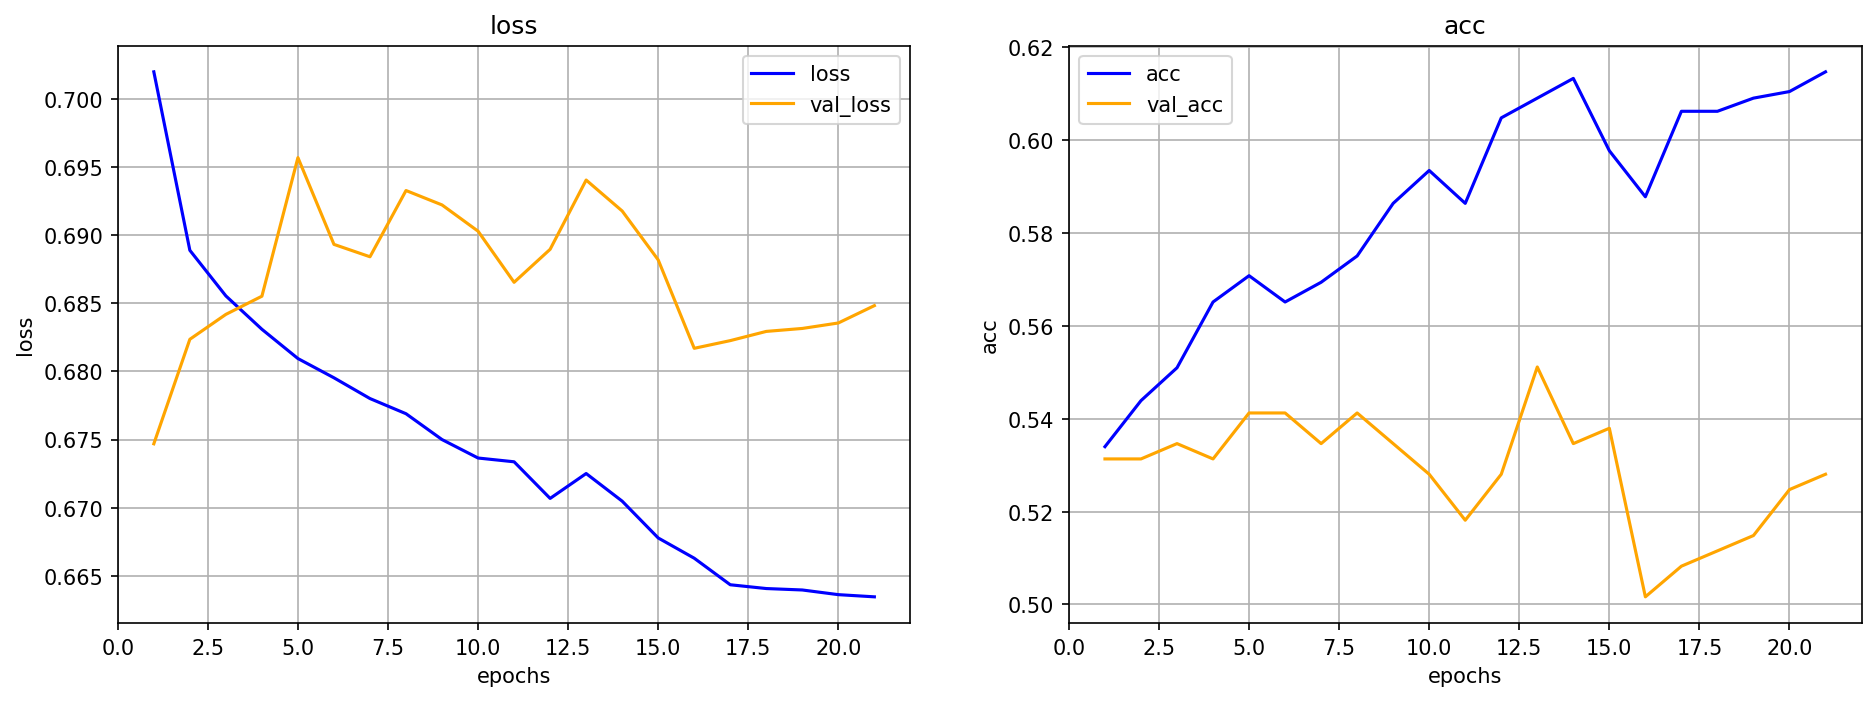

23/23 [==============================] - 0s 1ms/step - loss: 0.6631 - acc: 0.6147
최종 훈련 손실률: 0.663149, 최종 훈련 정확도: 0.614731
10/10 [==============================] - 0s 3ms/step - loss: 0.6848 - acc: 0.5281
최종 검증 손실률: 0.684834, 최종 검증 정확도: 0.528053


In [ ]:
result_df = DataFrame(result.history)
result_df['epochs'] = result_df.index+1
result_df.set_index('epochs', inplace= True)    
train_column_name = [result_df.columns[0], result_df.columns[1]]
test_column_name = [result_df.columns[2], result_df.columns[3]]

fig, ax = plt.subplots(1,2, figsize =(15,5), dpi = 150)
for i, v in enumerate(ax):
    sb.lineplot(x = result_df.index, y = train_column_name[i], data = result_df,  color = 'blue', label = train_column_name[i], ax =v)
    sb.lineplot(x = result_df.index, y = test_column_name[i], data = result_df, color = 'orange', label = test_column_name[i], ax =v)
    v.set_title(train_column_name[i])
    v.set_xlabel('epochs')
    v.set_ylabel(train_column_name[i])
    v.grid()
    v.legend()
plt.show()
plt.close()
evaluate1 = model.evaluate(x_train, y_train)
print("최종 훈련 손실률: %f, 최종 훈련 정확도: %f" % (evaluate1[0], evaluate1[1]))

evaluate2 = model.evaluate(x_test, y_test)
print("최종 검증 손실률: %f, 최종 검증 정확도: %f" % (evaluate2[0], evaluate2[1]))
